<a href="https://colab.research.google.com/github/JavierArroyoBastida/project1-boptest/blob/issue348_bs21Workshop/docs/tutorials/BS21Workshop_20210831/BOPTEST_Tutorial_BS2021Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a hands-on tutorial to guide you through the BOPTEST framework. 
The tutorial provides:



*   An overview of the BOPTEST project, goals and approach
*   Explanation for starting up a BOPTEST case
*   A guide through the BOPTEST API to interact with the case
*   Example for the development and evaluation of a simple feedback controller
*   Example of an MPC controller in the same test case
*   Guidelines to improve upon the previously developed feedback controller






---



---






# Introduction to the BOPTEST project

The Building Optimization Testing (BOPTEST) framework aims to assess and benchmark advanced algorithms for building HVAC control. 

An introduction to the BOPTEST project, goals and approach can be found in [this presentation](https://docs.google.com/presentation/d/18R3iOXAzxHbK1fHi5PxNNA1V-YLJdczPzxfDRynsQlg/edit?usp=sharing).

---

# Exercise 1: Development and evaluation of a simple feedback controller

## Introducrion 



This exercise explains how to set up a BOPTEST case, provides a guide through the API, and develops a simple feedback controller. 

BOPTEST cases are containerized environments with:

*   A detailed emulator building model.
*   Yearly boundary condition data for weather, pricing, and emission factors. These data are representative of the building location. 
*   Other auxiliary functionality like the capability to initialize a test case, advance a simulation, select a testing scenario, compute KPIs, or provide forecast data. 

The test case is accessed through an API described [here](https://github.com/ibpsa/project1-boptest).

The typical workflow to test a controller is:

1.   Select a building from the menu of available emulators. 
2.   Select a testing scenario. Testing scenarios are standardized for each emulator and last for two weeks. 
3.   Set control parameters like the control step or the forecast horizon, if required.  
4.   Run the simulation loop by interacting with your controller. 
5.   Request to get the KPIs to evaluate your controller performance. 



## Selecting a test case



We start by selecting and launching our own building test case. 
BOPTEST cases are hosted in a server to avoid the installation of any dependency. It is also possible to deploy a test case in your localhost with [Docker Desktop](https://www.docker.com/products/docker-desktop) which may speed up your simulations since you will be saving the wired time to reach the host every control step. In this tutorial we are going to use the server for convenience. However, the workflow when testing locally remains the same, and indications will be provided at the end of the tutorial. 

In this example we are going to work with the single-zone residential building with radiant floor heating and a heat pump. This is a high-fideligy yet relatively simple emulator that allows to focus on fundamental aspects of the framework. To connect to this test case we select it from the server as follows.
 The the Python `requests` library needs to be imported. 

In [209]:
import requests

# url for the BOPTEST service
# url = 'http://ec2-23-20-252-119.compute-1.amazonaws.com'
# I'm creating my own EC2 for making the workshop content. This url will change
url = 'http://ec2-3-144-27-177.us-east-2.compute.amazonaws.com' 

# Select test case and get identifier
testcase = 'bestest_hydronic_heat_pump'
testid = \
requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']


Notice that the test case has been selected based on its name. The list of currently [available test cases](https://github.com/ibpsa/project1-boptest/tree/master/testcases) is: 

*   `bestest_air`
*   `bestest_hydronic`
*   `bestest_hydronic_heat_pump`
*   `multizone_residential_hydronic`

But more test cases are expected to come soon. 

While the `url` is the common gateway for everyone to access the BOPTEST server, the `testid` is a unique identifier addressing to your particular test case. 
Once the `testid` is available, it is possible to start interactig with your test case as follows:

In [210]:
# Get test case name
name = requests.get('{0}/name/{1}'.format(url, testid)).json()
print(name)


{'name': 'bestest_hydronic_heat_pump'}


## Getting building information

All building information can be found under the documentation folder of the test case in: `/<testcasename>/doc/index.html`. 
This file includes a description of the building envelope, the HVAC system design, the functioning of the baseline controller, and the model inputs and outputs. 
Understanding how the system works is probably the most important practice for control design, so take as much time as needed to figure the equipment in place, the points that can be measured, and the setpoints that can be overwriten by your controller. 
We briefly summarize the `bestest_hydronic_heat_pump` case here for completeness, but it is strongly recommended to have a deeper look into the documentation. 

The building represents a residential dwelling of 192 $m^2$ for a family of 5 members. 
An air-to-water modulating heat pump of 15 $kW$ nominal heating capacity extracts energy from the ambient air to heat up the floor heating emission system, as shown in the figure below. 
A fan blows ambient air through the heat pump evaporator when the heat pump is operating. 
The floor heating system injects heat into the floor, with water as working fluid. 

![](https://drive.google.com/uc?export=view&id=1qAYEhwR3J8uABtmxmNeMetBWbGieLFcx)

A baseline controller comes along with every emulator and is meant to be representative of a typical controller of that building. 
The baseline controller can be considered as a first benchmark to beat. 
In our building, a PI controller is tuned with the zone operative temperature as the controlled variable and the heat pump modulation signal for compressor frequency as the control variable, as depicted as C1 in the figure above and shown in the figure below. 
The control variable is limited between 0 and 1, and it is computed to drive the zone operative temperature towards its setpoint, which is defined as a function of the occupancy schedule. 

![](https://drive.google.com/uc?export=view&id=1OC1ihYSdU3YUU7nKlqUwnzcbRyXxBtRu)

All other equipment (fan for the heat pump evaporator circuit and floor heating emission system pump) are switched on when the heat pump is working (modulating signal higher than 0) and switched off otherwise. 
This is depicted as controller C2. 

Another way of getting building information is by requesting it directly to the test case.
The inputs, outputs, or the control step can be obtained in this way:





In [211]:
# Get inputs available
inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()
print('TEST CASE INPUTS ---------------------------------------------')
print(inputs.keys())
# Get measurements available
print('TEST CASE MEASUREMENTS ---------------------------------------')
measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()
print(measurements.keys())
# Get default control step
step = requests.get('{0}/step/{1}'.format(url, testid)).json()
print('DEFAULT STEP PERIOD [seconds] --------------------------------')
print(step)


TEST CASE INPUTS ---------------------------------------------
dict_keys(['oveTSet_activate', 'ovePum_activate', 'ovePum_u', 'oveHeaPumY_u', 'oveTSet_u', 'oveHeaPumY_activate', 'oveFan_activate', 'oveFan_u'])
TEST CASE MEASUREMENTS ---------------------------------------
dict_keys(['weaSta_reaWeaPAtm_y', 'reaPFan_y', 'reaQHeaPumCon_y', 'reaTRet_y', 'weaSta_reaWeaNOpa_y', 'weaSta_reaWeaTBlaSky_y', 'reaQHeaPumEva_y', 'weaSta_reaWeaNTot_y', 'weaSta_reaWeaSolAlt_y', 'reaPum_y', 'reaTZon_y', 'weaSta_reaWeaHHorIR_y', 'weaSta_reaWeaLon_y', 'reaHeaPumY_y', 'weaSta_reaWeaSolTim_y', 'weaSta_reaWeaCloTim_y', 'reaPPumEmi_y', 'weaSta_reaWeaHGloHor_y', 'weaSta_reaWeaRelHum_y', 'reaTSetHea_y', 'reaFan_y', 'reaTSet_y', 'reaCO2RooAir_y', 'weaSta_reaWeaSolDec_y', 'reaPHeaPum_y', 'weaSta_reaWeaHDirNor_y', 'reaTSetCoo_y', 'weaSta_reaWeaWinDir_y', 'reaTSup_y', 'weaSta_reaWeaSolZen_y', 'reaQFloHea_y', 'reaCOP_y', 'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaTWetBul_y', 'weaSta_reaWeaTDewPoi_y', 'weaSta_reaWeaWin

`_y` indicates a measurement point, `_u` indicates a variable that can be overwriten by an external controller, and `_activate` indicates a boolean (0 or 1) to enable external inputs. 
Hence, `<varname>_u` is enabled for external control when `<varname>_activate=1`.
`weaSta_` indicates a measurement taken for a weather station of the building location, so that historical weather data can be easily retrieved. 
Notice that the requests for inputs and measurments also return a description of each variable:


In [212]:
print(inputs['oveHeaPumY_u']['Description'])
print(inputs['oveHeaPumY_u']['Minimum'])
print(inputs['oveHeaPumY_u']['Maximum'])

Heat pump modulating signal for compressor speed between 0 (not working) and 1 (working at maximum capacity)
0
1


In [213]:
print(measurements['reaTZon_y']['Description'])
print(measurements['reaTZon_y']['Minimum'])
print(measurements['reaTZon_y']['Maximum'])

Zone operative temperature
None
None


If an input variable is overwritten with a value above/below its maximum/minimum bound, then the maximum/minimum value is used instead. 

## Initializing the test case



The test case can be initialized by specifying the `start_time` in seconds from the beginning of the year and the `warmup_period` to simulate the emulator right before `start_time`. 
During warm-up, the baseline controller simulates the model to prepare it to a realistic operational state. 
Additonally, all configuration parameters are left to default to leave the test case in a totally clean status.
Let's initialize the test case for the February 1st with one week of warm-up period. 


In [214]:
y = requests.put('{0}/initialize/{1}'.format(url, testid), 
                 data={'start_time':   31*24*3600,
                       'warmup_period': 7*24*3600}).json()
print(y['reaTZon_y'])
print(y['time']/24/3600)

294.51444681632984
31.0


For the sake of benchmarking, specific scenario periods are predefined for each test case. 
These periods last for two weeks, with a one week warm-up period utilizing baseline control. 
The available scenario time periods for each test case are defined within their respective documentation. Currently, peak heating or cooling, typical heating or cooling, and mixed heating and cooling time period scenarios are consistently defined across available test cases.
Systems that do not have cooling only have the heating scenarios available.
More information about how the scenario periods are defined can be found [here](https://github.com/ibpsa/project1-boptest/issues/270). 

In addition to the testing period, a scenario is also defined by the electricity tariff, that can be `constant`, `dynamic`, or `highly_dynamic`. 
The dynamic pricing follows a day-night tariff and a highly dynamic pricing follows the wholesale electricity market for the building's location.
Both cases include a constant offset for transportation fees and taxes such that a realistic absolute pricing is used. 
See the README in the [testcases folder](https://github.com/ibpsa/project1-boptest) for options and test case documentation for details.

The `PUT /scenario` API call can be used to set a specific scenario. 
Similarly to `PUT /initialize`, this call uses a warm-up period to initialize the case but moves it to a predefined starting date.
All test case variables are also reset, and a variable is triggered that makes sure to stop at the end of the test, i.e. after precisely two weeks.  
The following shall be used to set the `peak_heat_scenario` with a `dynamic` electricity tariff:


In [215]:
scenario_return = requests.put('{0}/scenario/{1}'.format(url, testid), 
                  data={'time_period':'peak_heat_day',
                        'electricity_price':'dynamic'}).json()

Note that setting the scenario API call returns two arguments: the `'time_period'` with the initial measurements of the scenario time period, and the `'electricity_price'` that will be `True` if succeeded in changing the electricity price tariff.


In [216]:
y = scenario_return['time_period']
start_time_days = y['time']/24/3600
print(y['time']/24/3600)
print(y['reaTZon_y']-273.15)
print(scenario_return['electricity_price'])

16.0
21.31439191282618
True


To check the current test case scenario use the call to get the scenario:

In [217]:
requests.get('{0}/scenario/{1}'.format(url, testid)).json()

{'electricity_price': 'dynamic', 'time_period': 'peak_heat_day'}

## Advancing the simulation

When no inputs are provided, the simulation is advanced with the baseline controller. For instance, the following advances the simulation for one control step (3600 seconds by default) and using the baseline controller. 

In [218]:
y = requests.post('{0}/advance/{1}'.format(url, testid), data={}).json()

No inputs are overwriten because an empty dictionary (`data={}`) has been sent. However, the simulation has advanced one hour with the baseline controller from the initial time of the `peak_heat_period` scenario where we moved our test case. 

In [219]:
print(y['time']/24/3600)
print(y['reaTZon_y']-273.15)

16.041666666666668
21.4063979568582


In order to overwrite the heat pump modulation signal it is needed to activate this signal when advancing the simulation and to pass the desired value.
The following advances the simulation with the heat pump at half of its capacity for one hour. 
Remember that the evaporator fan and the circulation pump will be automatically switched on because of controller C2.  

In [220]:
u = {'oveHeaPumY_u':0.5,
     'oveHeaPumY_activate': 1}
y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()
print(y['time']/24/3600)
print(y['reaTZon_y']-273.15)


16.083333333333332
21.415455010972664


## Getting results

The simulation results can be obtained at every time with the `GET /results` API call. The point to be retrieved needs to be specified, as in an actual building management system. 

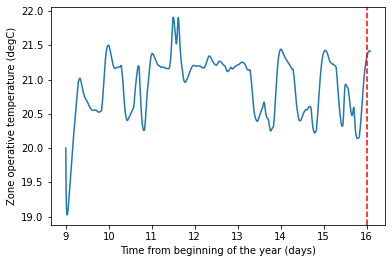

In [221]:
import numpy as np
import matplotlib.pyplot as plt

args = {'point_name':'reaTZon_y','start_time':-np.inf, 'final_time':np.inf}
res = requests.put('{0}/results/{1}'.format(url, testid), data=args).json()
plt.plot(np.asarray(res['time'])/24/3600, np.asarray(res['reaTZon_y'])-273.15)
plt.xlabel('Time from beginning of the year (days)')
plt.ylabel('Zone operative temperature (degC)')
plt.axvline(start_time_days, linestyle='--', color='r')

Note that most of the simulation results correspond to the one week warm-up period, and only a small part to the steps advanced during the actual scenario period. 
The results are provided also during the initialization period such that advanced controllers like MPC could use them to initialize their controls, e.g. with state estimation. 

The core KPIs are defined in BOPTEST to evaluate different aspects of a controller. These are:

*   **Thermal discomfort**:  reported with units of [$K \, h/zone$], defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case FMU for each zone, averaged over all zones.  Air temperature is used for air-based systems and operative temperature is used for radiant systems.
*   **Indoor Air Quality (IAQ) Discomfort**: reported with units of [$ppm \, h/zone$], defines the extent that the CO$_2$ concentration levels in zones exceed  bounds of the acceptable concentration level, which are predefined within the test case FMU for each zone, averaged over all zones.
*   **Energy Use**: reported with units of [$kWh/m^2$], defines the HVAC energy usage. 
*   **Cost**: reported with units of [USD/$m^2$] or [EUR/$m^2$], defines the cost associated with the HVAC energy usage.
*   **Emissions**: reported with units of  [$kg \, CO_2/m^2$], defines the CO$_2$ emissions from the HVAC energy usage.
*   **Computational time ratio**: defines the average ratio between the controller computation time and the test simulation control step. The controller computation time is measured as the time between two emulator simulations.

The core KPIs are normally calculated at the end of the simulation to assess the controller performance, although they can be computed at any time. 
The initialization period is not taken into account for the calculation of the KPIs.



In [222]:
requests.get('{0}/kpi/{1}'.format(url, testid)).json()

{'cost_tot': 0.006766128663417423,
 'emis_tot': 0.004741684795596767,
 'ener_tot': 0.028393322129321955,
 'idis_tot': 0.0,
 'tdis_tot': 0.0,
 'time_rat': 0.0013433124621709189}

## Simulating the baseline for benchmarking

We reinitialize the test case to return it to a clean state and record the KPIs of the baseline after simulation for future comparison. 
The baseline can be quickly simulated by setting a long control step and without overwritting any control signal when advancing the simulation.
Particularly, we set the control step to one year to prove that the simulation is forced to stop after two weeks when using the standardized scenario periods. 


In [223]:
requests.put('{0}/scenario/{1}'.format(url, testid), 
              data={'time_period':'peak_heat_day',
                    'electricity_price':'dynamic'}).json()
requests.put('{0}/step/{1}'.format(url, testid), data={'step':365*24*3600})
requests.post('{0}/advance/{1}'.format(url, testid), data={}).json()
kpis_bas = requests.get('{0}/kpi/{1}'.format(url, testid)).json()
kpis_bas

{'cost_tot': 0.8828697723365668,
 'emis_tot': 0.5808439890819883,
 'ener_tot': 3.478107719053822,
 'idis_tot': 0.0,
 'tdis_tot': 8.38250234234847,
 'time_rat': 1.2137689970278727e-06}

The following function can be used for a time series visualization of the results:

In [224]:
import pandas as pd
def get_and_plot_results(testid, start_time, final_time):
    df_res = pd.DataFrame()
    for point in ['reaTZon_y', 'reaTSetHea_y', 'reaTSetCoo_y', 'reaHeaPumY_y', 
                  'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaHDirNor_y']:
        # Retrieve full simlation year to ensure we get all data
        args = {'point_name':point,
                'start_time':start_time, 
                'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], 
                            index=res['time'],columns=[point])), axis=1)
    df_res.index.name = 'time'
    plt.close()
    _, axs = plt.subplots(3, sharex=True, figsize=(8,6))
    x_time = df_res.index/3600./24.
    # Plot operative temperature
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, 'darkorange', 
                linestyle='-', linewidth=0.8, label='$T_z$')
    axs[0].plot(x_time, df_res['reaTSetHea_y'] - 273.15, 'gray', 
                linewidth=0.8, label='Comfort setp.')
    axs[0].plot(x_time, df_res['reaTSetCoo_y'] - 273.15, 'gray', 
                linewidth=0.8, label='_nolegend_')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n($^\circ$C)')
    axs[0].legend()
    # Plot heat pump modulation signal
    axs[1].plot(x_time, df_res['reaHeaPumY_y'], 'darkorange',     
                linestyle='-', linewidth=0.8, label='$u_{hp}$')
    axs[1].set_ylabel('Heat pump\nmodulation\nsignal\n( - )')
    axs[1].legend()
    # Plot disturbances
    axs[2].plot(x_time, df_res['weaSta_reaWeaTDryBul_y'] - 273.15, 'royalblue', 
                linestyle='-', linewidth=0.8, label='$T_a$')
    axs[2].set_ylabel('Ambient\ntemperature\n($^\circ$C)')
    axs[2].set_yticks(np.arange(-5, 16, 5))
    axs[2].legend(loc='upper left')
    axs[2].set_xlabel('Day of the year')
    axt = axs[2].twinx()
    axt.plot(x_time, df_res['weaSta_reaWeaHDirNor_y'], 'gold', 
             linestyle='-', linewidth=0.8, label='$\dot{Q}_{rad}$')
    axt.set_ylabel('Solar\nirradiation\n($W$)')
    axt.legend(loc='upper right')
    plt.show()  

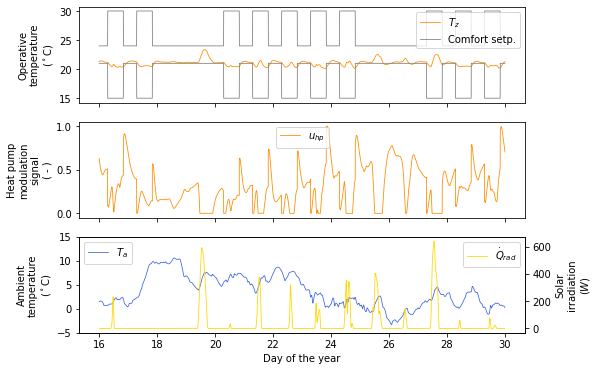

In [225]:
get_and_plot_results(testid, start_time=start_time_days*24*3600, final_time=np.inf)

---

## Assessing your own control algorithm

Now that we know how to initialize a test case, advance a simulation and obtain results, it is time to implement and assess our own control algorithm. 
For this example we are going to implement a very simple proportional controller that will determine the heat pump modulation signal as a function of the zone operative temperature.
No other variables need to be overwritten since the subcontroller C2 will switch on the heat pump fan and the circulation pump every time we send a control signal with `oveHeaPumY_u>0`. 
Only two parameters need tuning: the temperature setpoint and the proportionality constant: 

In [226]:
class Controller_Proportional(object):
    
    def __init__(self, TSet=273.15+21, k_p=10.):
        '''Constructor.

        Parameters
        ----------
        TSet : float, optional
            Temperature set-point.
        k_p : float, optional
            Proportionality constant. 
            
        '''
        
        self.TSet = TSet
        self.k_p  = k_p
    
    def compute_control(self, y):
        '''Compute the control input from the measurement.
    
        Parameters
        ----------
        y : dict
            Contains the current values of the measurements.
            {<measurement_name>:<measurement_value>}
    
        Returns
        -------
        u : dict
            Defines the control input to be used for the next step.
            {<input_name> : <input_value>}
    
        '''
    
        # Compute control
        if y['reaTZon_y']<self.TSet:
            e = self.TSet - y['reaTZon_y']
        else:
            e = 0
    
        value = self.k_p*e
        u = {'oveHeaPumY_u':value,
             'oveHeaPumY_activate': 1}
    
        return u

Now let's initialize the test case in the same scenario that we used to obtain the baseline KPIs, that is, the peak heating period with dynamic pricing. 
This time we set the control step to be of one hour. 
After that, we instantiate the controller and define a simulation loop. 
Note that the test case will return an empty dictionary when the testing period has elapsed, such that we can loop over the returned measurements without having to infer when the simulation time should end.

In [227]:
y = requests.put('{0}/scenario/{1}'.format(url, testid), 
                 data={'time_period':'peak_heat_day',
                       'electricity_price':'dynamic'}).json()['time_period']
requests.put('{0}/step/{1}'.format(url, testid), data={'step':3600})

con = Controller_Proportional(TSet=273.15+21, k_p=5.)

# Simulation loop
from IPython.display import clear_output
while y:
    clear_output(wait=True)
    print('-------------------------------------------------------------------')
    print('Operative temperature  = {:.2f}'.format(y['reaTZon_y']-273.15))
    simulation_time_days = y['time']/3600/24
    print('Simulation time (days) = {:.2f}'.format((simulation_time_days - \
                                                    start_time_days)))
    print('-------------------------------------------------------------------')
    # Compute control signal 
    u = con.compute_control(y)
    # Advance simulation with control signal
    y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()    


-------------------------------------------------------------------
Operative temperature  = 20.81
Simulation time (days) = 14.00
-------------------------------------------------------------------


After the simulation is done, we can plot the results, obtain KPIs and compare with those obtained for the baseline controller:

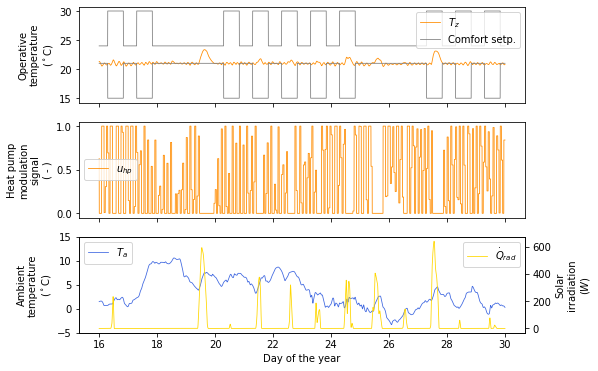

In [228]:
get_and_plot_results(testid, start_time=start_time_days*24*3600, final_time=np.inf)

In [229]:
kpis_con = requests.get('{0}/kpi/{1}'.format(url, testid)).json()
kpis_con

{'cost_tot': 0.7025804273828494,
 'emis_tot': 0.4612590709883337,
 'ener_tot': 2.762030365199603,
 'idis_tot': 0.0,
 'tdis_tot': 19.214004362870106,
 'time_rat': 5.0304873603584355e-05}

In [230]:
kpis_bas

{'cost_tot': 0.8828697723365668,
 'emis_tot': 0.5808439890819883,
 'ener_tot': 3.478107719053822,
 'idis_tot': 0.0,
 'tdis_tot': 8.38250234234847,
 'time_rat': 1.2137689970278727e-06}

Our controller does not improve the results so far. 
Contrarily, it substantially increases thermal discomfort. 
You may want to re-run the previous cells with different values of `TSet` and `k_p` to find a good balance between comfort and operational cost. 
Feel free to set other control steps, use other measurements, or change the test case scenario. 

# Example MPC controller

An example of the implementation and evaluation of an MPC for the BOPTEST case of this tutorial can be found in [this presentation](https://docs.google.com/presentation/d/1LjJLFKltNW7ez-TchkBA5lCtgfj5lpggBFBDK8clVCk/edit?usp=sharing). 

---

# Exercise 2: Timed common exercise

The goal of this part of the tutorial is to optimize the controller developed in Exercise 1 by further tuning for energy, energy cost, and discomfort reduction. Team-work is encouraged from this point. 

---

# Wrap-up and follow up exercise

A summary of the workshop content and introduction to the off-line competition can be found in [this presentation](https://docs.google.com/presentation/d/1PvYuFNh7aZ59rzoz7__rHW_0QXo3G0_UhA7XrNeqpFc/edit?usp=sharing). 